In [1]:
from __future__ import division, absolute_import

import numpy as np

from bcn.bias import guess_func
from bcn.data import DataSimulated, estimate_partial_signal_characterists
from bcn.cost import Cost
from bcn.solvers import ConjugateGradientSolver
from bcn.linear_operators import LinearOperatorCustom, LinearOperatorEntry, possible_measurements
from bcn.utils.visualization import *

In [2]:
np.random.seed(seed=42)

## Case study: Data normalization for unknown confounding factors!


### Outline
1. Description of common use cases.
2. Creation of two corrupted datasets (**A** and **B**).
3. Application of matrix recovery.
    - Dataset **A** with entry sensing.    
    - Dataset **B** with blind normalization.
4. Discussion of results and advantages.


### 1. Use cases

You have to work with two datasets that are corrupted by an unknown number of confounding factors. Both datasets consist of a matrix of samples and features. For example, customers and products with a rating of satisfaction, or location and time of temperature measurements accross the globe, or the change in value of stocks at closing time at the financial markets. Thus, values in the matrix are continuous and can range from negative to positive.

Luckily, for dataset **A** you were able to determine the true values for a small subset of matrix entries, for example through quantitative measurement standards or time intensive in-depth analysis. Thus, the recovery of confounding factors is similar to a matrix recovery problem solvable through entry sensing, as the observed values subtracted by the true values give the necessary entries for the bias matrix of confounding factors to be recovered. 

For dataset **B** it is more challenging, as you were not able to determine any true values for its entries. However, instead you know with certainty that several of the samples and several of the features are strongly correlated and that you are likely to be able to identify those, as the corruption through the confounding factors is not stronger than the underlying signal. Thus the problem can be approached by blind normalization.

In order to remove the unknown confounding factors several assumptions have to be satisfied for dataset **A** and **B**. First of all, the to be recovered bias matrix must lie on a sufficiently low dimensional manifold, such as one modelled by a low rank matrix. Secondly, the dataset must satisfy certain incoherence requirements. If both assumptions are satisfied, the otherwise NP-HARD recovery problem can be solved efficiently in the framework of compressed sensing. 

### 2. Creation of dataset **A** and **B**

In [3]:
# Setup of general parameters for the recovery experiment.
n_restarts = 10
rank = 6
n_measurements = 2800
shape = (50, 70) # samples, features
missing_fraction = 0.1
noise_amplitude = 2.0
m_blocks_size = 5 # size of each block
correlation_threshold = 0.75
correlation_strength = 1.0
bias_model = 'image'

In [4]:
# Creation of the true signal for both datasets.
truth = DataSimulated(shape, rank, bias_model=bias_model, correlation_threshold=correlation_threshold, m_blocks_size=m_blocks_size, noise_amplitude=noise_amplitude, correlation_strength=correlation_strength, missing_fraction=missing_fraction)

/home/sohse/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [5]:
true_bias = truth.d['sample']['true_bias']
true_bias_unshuffled = truth.d['sample']['true_bias_unshuffled']
true_signal = truth.d['sample']['signal']
true_signal_unshuffled = truth.d['sample']['signal_unshuffled']

In [6]:
true_correlations = {'sample': truth.d['sample']['true_correlations'], 'feature': truth.d['feature']['true_correlations']}
true_correlations_unshuffled = {'sample': truth.d['sample']['true_correlations_unshuffled'], 'feature': truth.d['feature']['true_correlations_unshuffled']}
true_pairs = {'sample': truth.d['sample']['true_pairs'], 'feature': truth.d['feature']['true_pairs']}
true_pairs_unshuffled = {'sample': truth.d['sample']['true_pairs_unshuffled'], 'feature': truth.d['feature']['true_pairs_unshuffled']}
true_directions = {'sample': truth.d['sample']['true_directions'], 'feature': truth.d['feature']['true_directions']}
true_stds = {'sample': truth.d['sample']['true_stds'], 'feature': truth.d['feature']['true_stds']}

In [7]:
# Creation of the corrupted signal for both datasets.

In [8]:
mixed = truth.d['sample']['mixed']

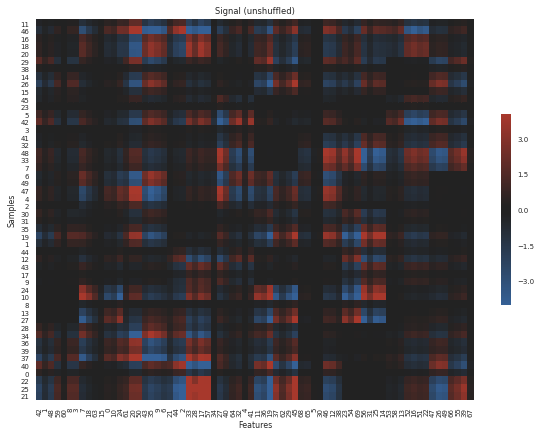

In [9]:
show_absolute(true_signal_unshuffled, kind='Signal', unshuffled=True, map_backward=truth.map_backward)

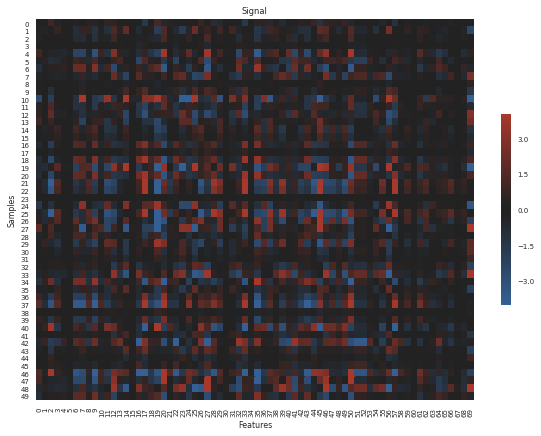

In [10]:
show_absolute(true_signal, kind='Signal')

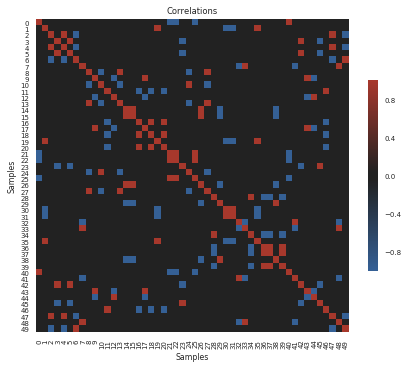

In [11]:
show_dependence_structure(true_correlations, 'sample')

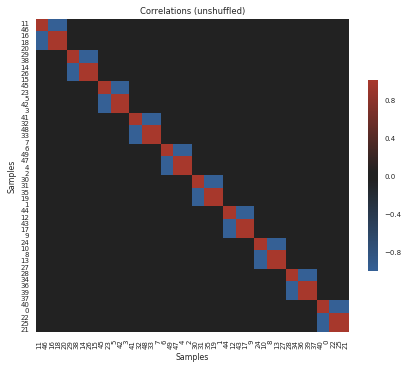

In [12]:
show_dependence_structure(true_correlations_unshuffled, 'sample', unshuffled=True, map_backward=truth.map_backward)

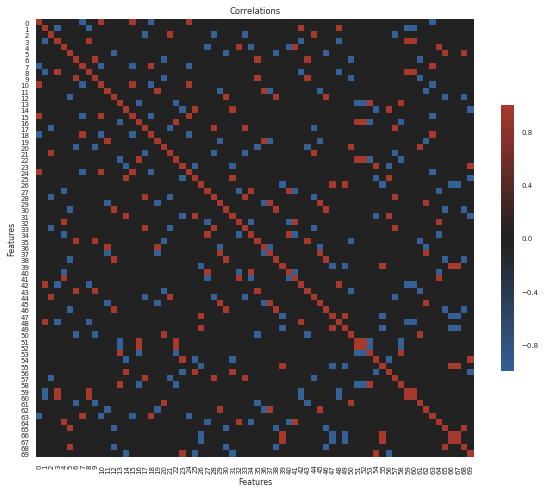

In [13]:
show_dependence_structure(true_correlations, 'feature')

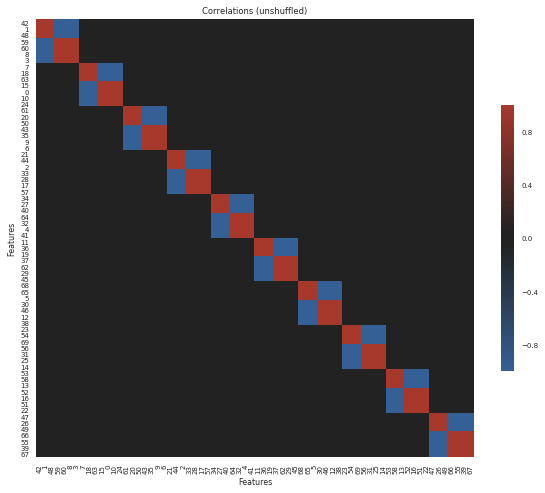

In [14]:
show_dependence_structure(true_correlations_unshuffled, 'feature', unshuffled=True, map_backward=truth.map_backward)

/home/sohse/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


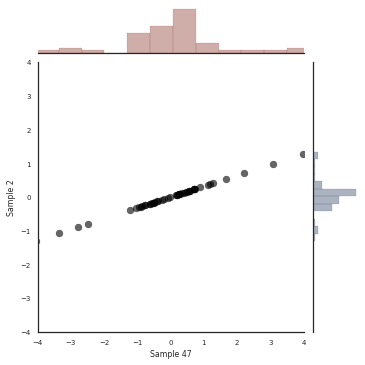

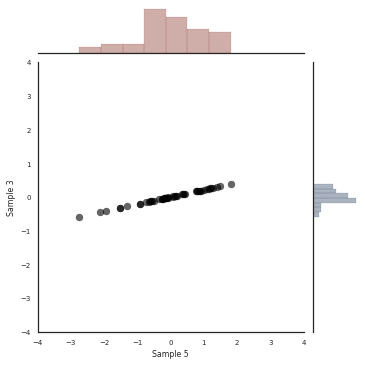

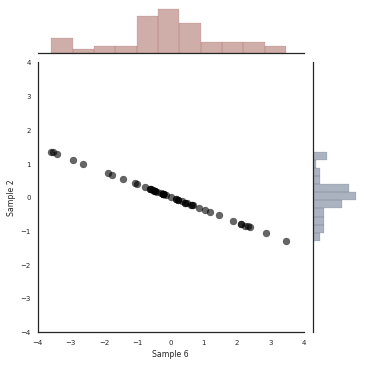

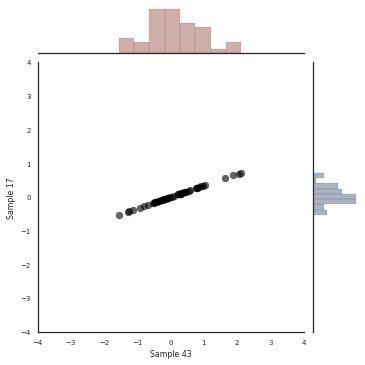

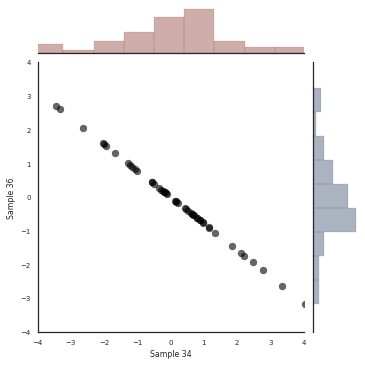

In [15]:
show_dependences(true_signal, true_pairs, 'sample')

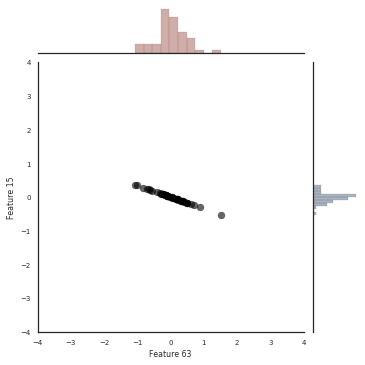

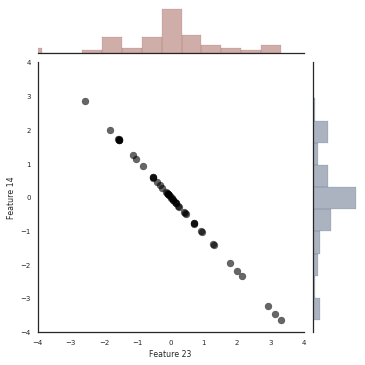

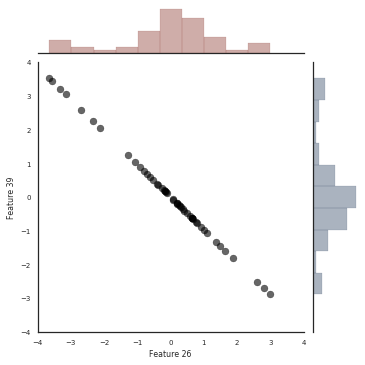

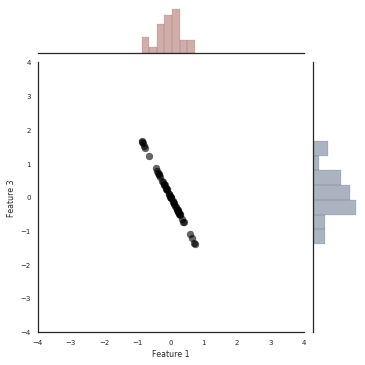

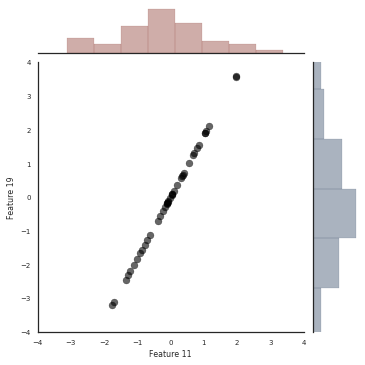

In [16]:
show_dependences(true_signal, true_pairs, 'feature')

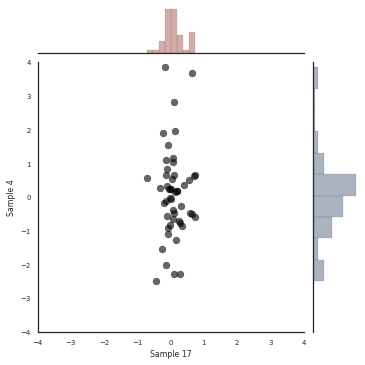

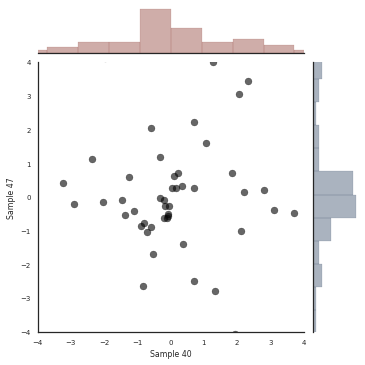

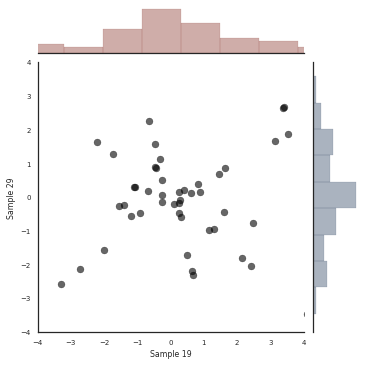

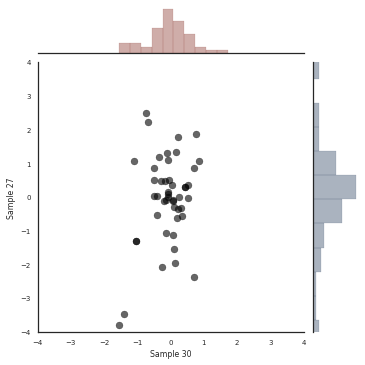

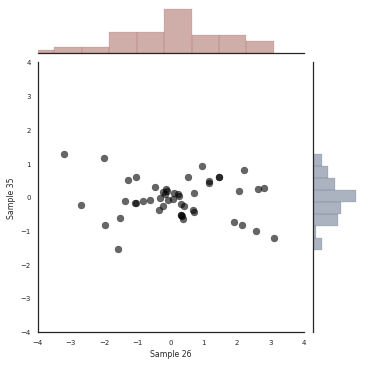

In [17]:
show_independences(true_signal, true_pairs, 'sample')

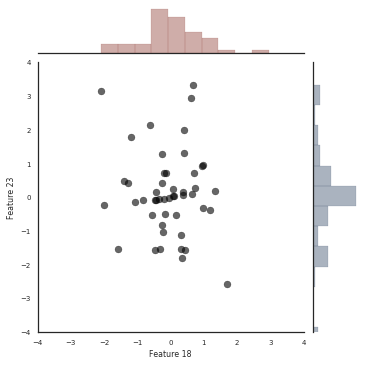

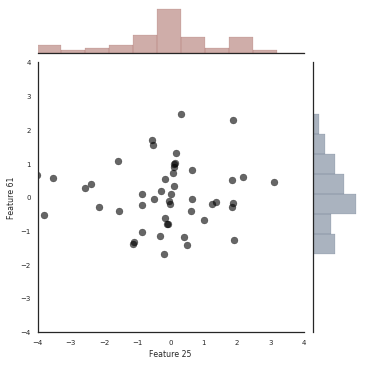

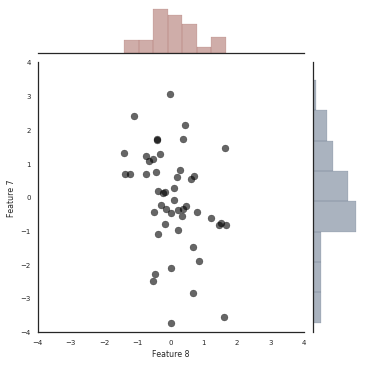

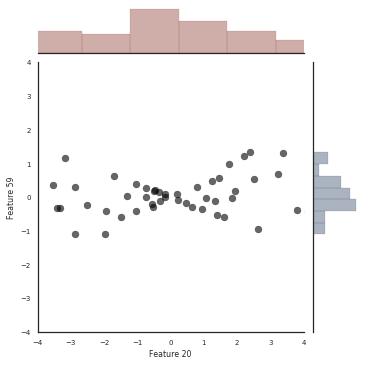

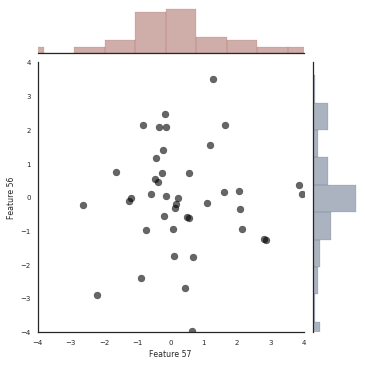

In [18]:
show_independences(true_signal, true_pairs, 'feature')

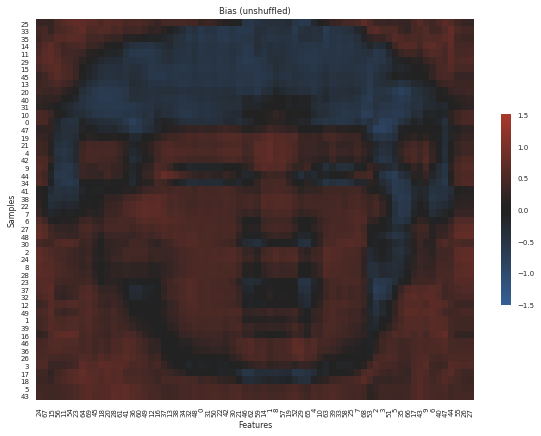

In [19]:
show_absolute(true_bias_unshuffled, unshuffled=True, map_backward=truth.map_backward_bias, kind='Bias', vmin=-1.5, vmax=1.5)

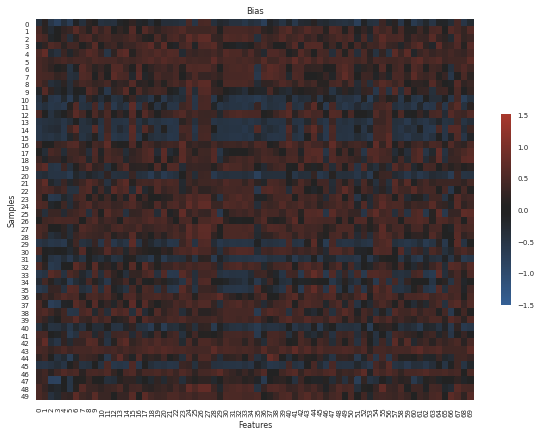

In [20]:
show_absolute(true_bias, kind='Bias', vmin=-1.5, vmax=1.5)

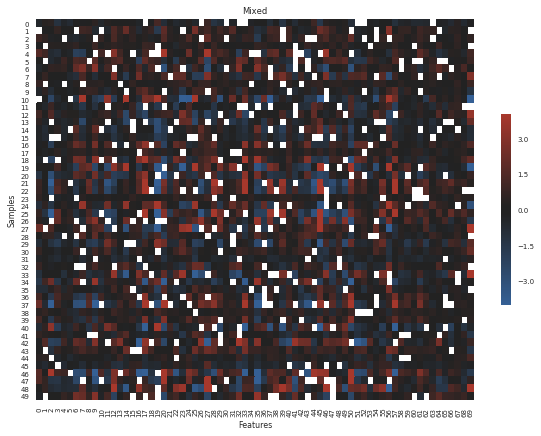

In [21]:
# Here the white dots are missing values as common in real data.
show_absolute(mixed, kind='Mixed')

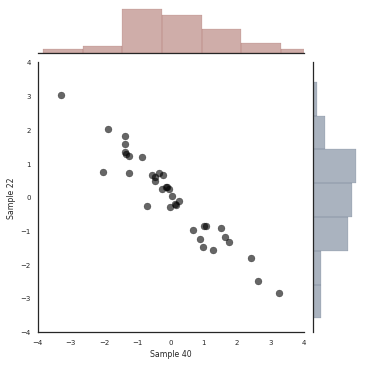

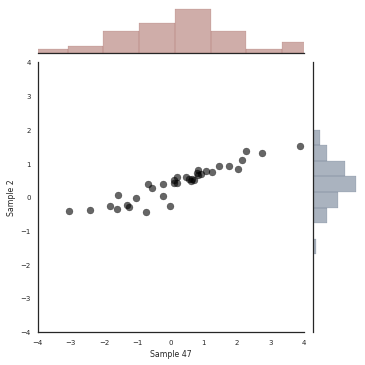

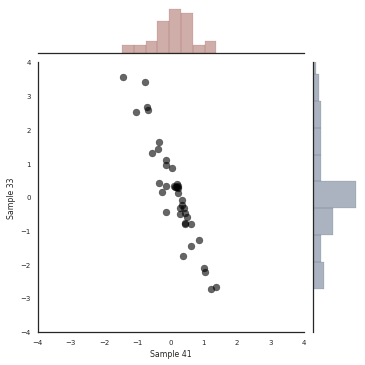

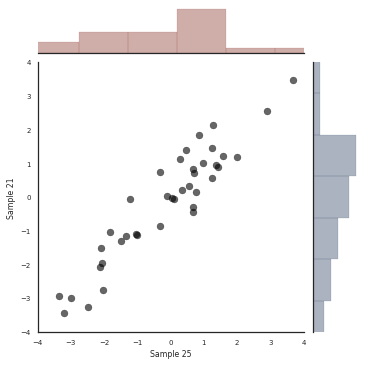

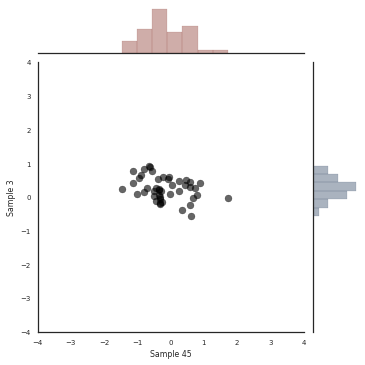

In [22]:
show_dependences(mixed, true_pairs, 'sample')

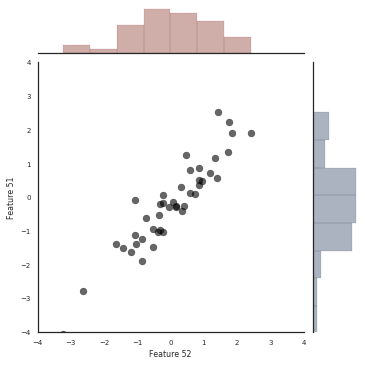

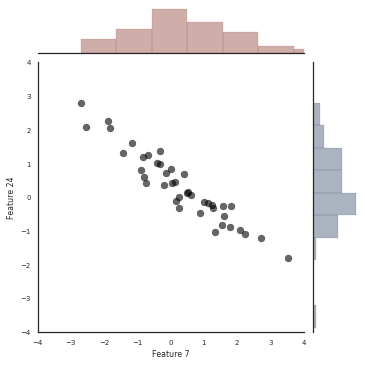

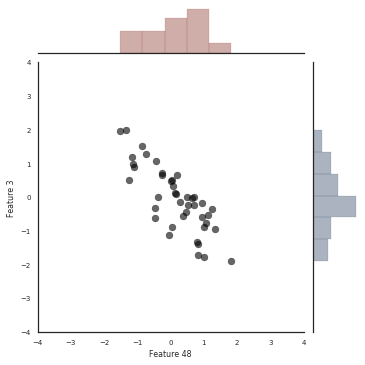

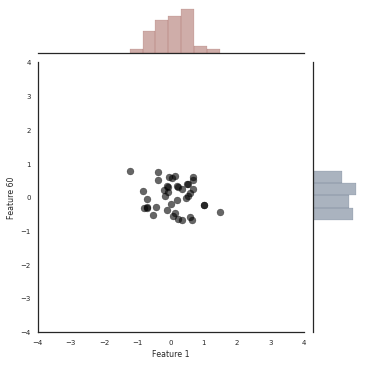

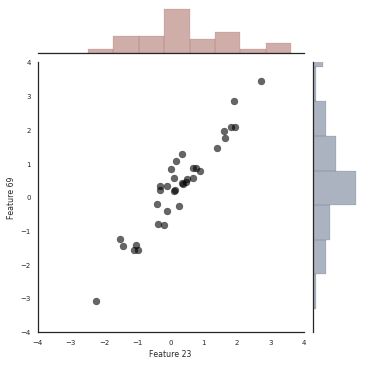

In [23]:
show_dependences(mixed, true_pairs, 'feature')

### 3. Normalization of dataset **A** with entry sensing  

In [24]:
# Construct measurements from known entries.
operator = LinearOperatorEntry(n_measurements)
measurements = operator.generate(true_bias)

In [25]:
# Construct cost function.
cost = Cost(measurements['A'], measurements['y'], sparsity=1)

In [26]:
# Recover the bias.
solver = ConjugateGradientSolver(mixed, cost.cost_func, guess_func, rank, guess_noise_amplitude=noise_amplitude, verbosity=0)
results = solver.recover()

In [27]:
# Recovery performance statistics.
recovery_performance(mixed, cost.cost_func, truth.d['sample']['true_bias'], results['estimated_signal'], truth.d['sample']['signal'], results['estimated_bias'])

Error cost function (true bias): 0.0
Error cost function (estimated bias): 8.223172312721887e-23
Number of valid values in corrupted signal: 3150
Mean absolute error (true_signal): 2.1032179800671898e-17
Mean absolute error (estimated_signal): 6.201978201733065e-12
Mean absolute error (zeros): 0.374993932915648
Ratio mean absolute error (estimated signal / zeros): 1.653887611863884e-11


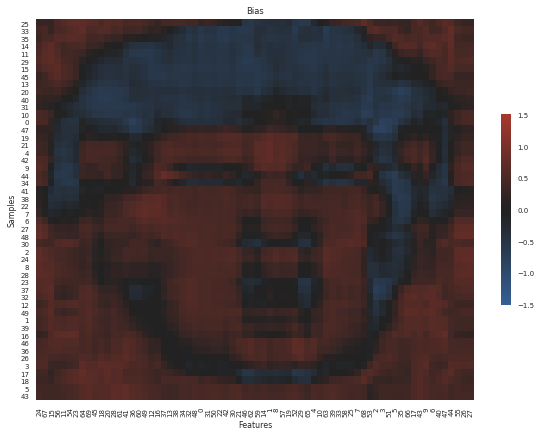

In [28]:
show_absolute(results['estimated_bias'], kind='Bias', unshuffle=True, map_backward=truth.map_backward_bias, vmin=-1.5, vmax=1.5)

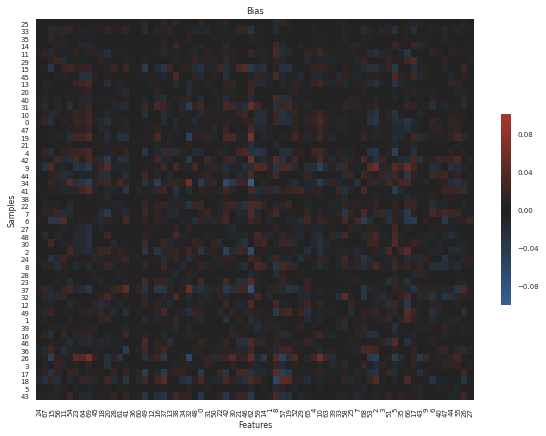

In [29]:
show_absolute(results['guess_X'], kind='Bias', unshuffle=True, map_backward=truth.map_backward_bias, vmin=-0.1, vmax=0.1)

### 3. Normalization of dataset **B** with blind normalization

In [30]:
possible_measurements(shape, missing_fraction, m_blocks_size=m_blocks_size)

{'m_blocks=(10, 14) (actual case)': 'TODO',
 'm_blocks=(2, 2) (worst case)': 3150,
 'm_blocks=(25, 35) (best case)': 91350}

In [31]:
# Prior information estimated from the corrputed signal and used for blind recovery.
signal_characterists = estimate_partial_signal_characterists(mixed, correlation_threshold, true_pairs=true_pairs, true_directions=true_directions, true_stds=true_stds)

In [32]:
estimated_correlations = {'sample': signal_characterists['sample']['estimated_correlations'], 'feature': signal_characterists['feature']['estimated_correlations']}

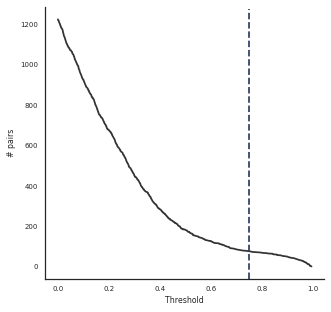

In [33]:
show_threshold(estimated_correlations, correlation_threshold, 'sample')

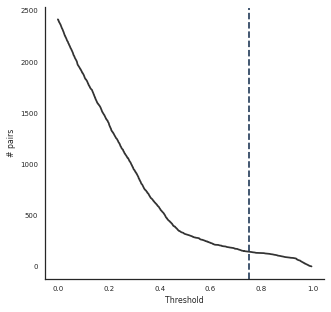

In [34]:
show_threshold(estimated_correlations, correlation_threshold, 'feature')

In [35]:
# Construct measurements from corrupted signal and its estimated partial characteristics.
operator = LinearOperatorCustom(n_measurements)
measurements = operator.generate(signal_characterists)

In [36]:
# Construct cost function.
cost = Cost(measurements['A'], measurements['y'], sparsity=2)

In [37]:
# Recover the bias.
solver = ConjugateGradientSolver(mixed, cost.cost_func, guess_func, rank, guess_noise_amplitude=noise_amplitude, verbosity=0)
results = solver.recover()

In [38]:
recovery_performance(mixed, cost.cost_func, truth.d['sample']['true_bias'], results['estimated_signal'], truth.d['sample']['signal'], results['estimated_bias'])

Error cost function (true bias): 5.343388306330877e-15
Error cost function (estimated bias): 2.723861784183101e-15
Number of valid values in corrupted signal: 3150
Mean absolute error (true_signal): 2.1032179800671898e-17
Mean absolute error (estimated_signal): 2.982244866698558e-08
Mean absolute error (zeros): 0.374993932915648
Ratio mean absolute error (estimated signal / zeros): 7.952781645055017e-08


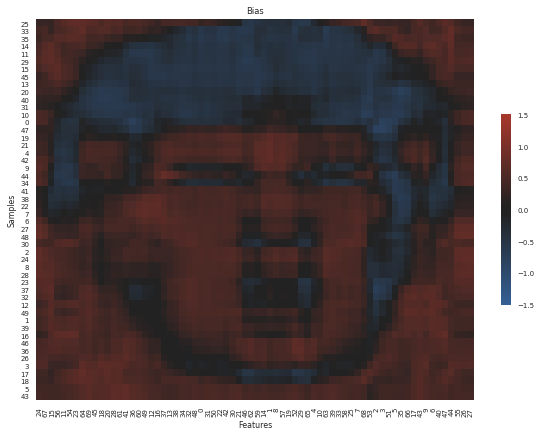

In [39]:
show_absolute(results['estimated_bias'], kind='Bias', unshuffle=True, map_backward=truth.map_backward_bias, vmin=-1.5, vmax=1.5)

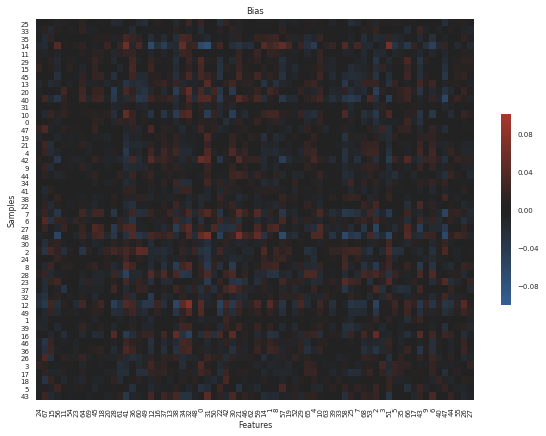

In [40]:
show_absolute(results['guess_X'], kind='Bias', unshuffle=True, map_backward=truth.map_backward_bias, vmin=-0.1, vmax=0.1)

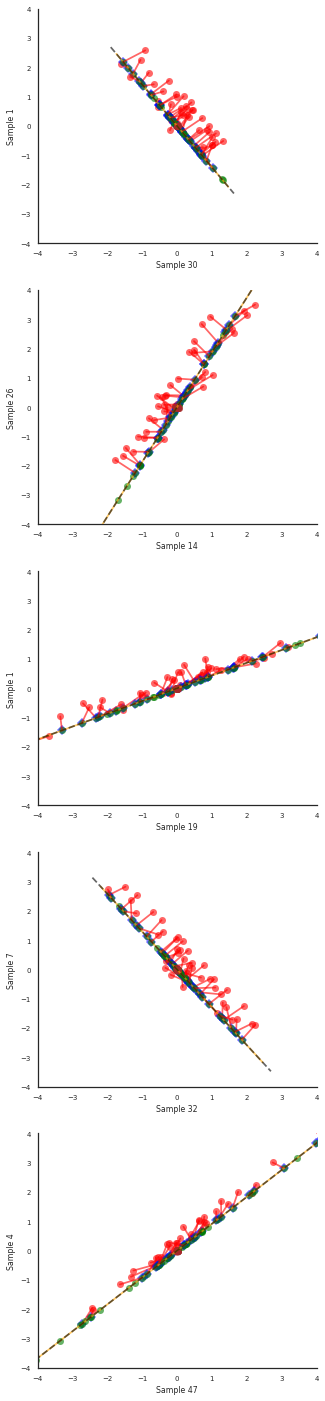

In [41]:
# Here red dots are the corrupted signal, green the clean signal, and blue the recovered signal.
# Note: missing blue dots indicate missing values.
show_recovery(mixed, results['guess_X'], true_signal, results['estimated_signal'], true_pairs['sample'], signal_characterists['sample']['estimated_pairs'], true_stds['sample'], signal_characterists['sample']['estimated_stds'], true_directions['sample'], signal_characterists['sample']['estimated_directions'], n_pairs=5, n_points=50)

### 4. Discussion

It can be observed that both recovery approaches are effective in a setting where the underling signal contains strong correlations (which can be accurately estimated) or known values are avaible for some of the bias matrix entries. Notably, the signal is not modelled explicitly but the systematics bias affecting it is modelled instead, allowing for complex non-linear signals to be normalized.

The corruptions is modelled here as low dimensional manifold, specifically a low rank matrix, which is a flexible model that can effectively approximate any combination of confounding factors. The systematic bias recovered with the two approaches can be further analysed to understand what confounding factors are important contributors to the corruption affecting the signal.

The more inaccurate the estimates of correlations and standard deviations become, the more challenging becomes the recovery for the blind normalization approach. However, incorrectly estimated correlated pairs of features (or samples) are less important for solver convergence. It remains to be determined to what extend the estimated standard deviations and directions must correspond the a sub-gaussian distribution in practice, for recovery to be successfull.  
